### ANALYSIS OF THE EFFECTIVENESS OF TWO MAIN PAGE OPTIONS FOR COMPANY's WEBSITE

A travel company plans to launch a new promotion to sell as many tours as possible. The team developed two versions of the landing page for the official website and conducted A/B testing. As a result of the experiment, data was collected

The main task: analyze the effectiveness of both landing page options according to two criterias at once - purchase conversion and daily average check.

Answer the travel agency’s key question: which landing page option is more preferable in terms of conversion metrics and daily average check?

So, the company offers the following tour options:
* Thailand - 100,000 rubles;
* Türkiye - 60,000 rubles;
* Maldives - 200,000 rubles;
* St. Petersburg - 10,000 rubles;
* Kamchatka - 150,000 rubles.


In [57]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.proportion import proportions_ztest
from scipy.stats import shapiro
from scipy.stats import ttest_ind
from scipy.stats import norm
from scipy.stats import t

import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn

In [58]:
df = pd.read_csv('data/ab_data_tourist.csv')
df.head(3)

,user_id,date,group,purchase,price
0,851104,2021-01-21,A,0,0
1,804228,2021-01-12,A,0,0
2,661590,2021-01-11,B,0,0



        user_id — identifier of the user who visited the site;
        data — date of site visit;
        group — test group (control — A or test — B);
        purchase — purchase sign: whether the user made a purchase of the tour (1 — yes, 0 — no);
        price — the price of the purchased tour (if the purchase did not take place, the price is 0).

### 1. Data structure analysis and preprocessing:
* research of data structure;
* converting columns to the required data types.
* Make sure that the duration of A/B testing is the same in each group.
* Checking data for gaps.
* Checking whether there are users who fell into both groups during the A/B test.


In [59]:
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   user_id   294478 non-null  int64         
 1   date      294478 non-null  datetime64[ns]
 2   group     294478 non-null  object        
 3   purchase  294478 non-null  int64         
 4   price     294478 non-null  int64         
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 11.2+ MB


In [60]:
df.groupby('group')['date'].describe()

,count,mean,min,25%,50%,75%,max
group,,,,,,,
A,147202,2021-01-13 01:55:49.470795520,2021-01-02 00:00:00,2021-01-08 00:00:00,2021-01-13 00:00:00,2021-01-19 00:00:00,2021-01-24 00:00:00
B,147276,2021-01-13 01:23:47.034955008,2021-01-02 00:00:00,2021-01-08 00:00:00,2021-01-13 00:00:00,2021-01-19 00:00:00,2021-01-24 00:00:00


In [61]:
ids_a = set(df[df['group']=='A']['user_id'].unique()) 
ids_b = set(df[df['group']=='B']['user_id'].unique())
print(f"Users_ids appeared in both groups: {len(ids_a&ids_b)}")

# exlude users that present in both groups
df = df[~df['user_id'].isin(ids_a&ids_b)]
df.shape

Users_ids appeared in both groups: 1895


(290688, 5)

In [62]:
print(f"Duplicates found: {df[df.duplicated()].shape[0]}")
df = df.drop_duplicates()
df.shape

Duplicates found: 74


(290614, 5)


    * The duration of testing in both groups is the same
    * there are no nan in the data
    * 1895 test participants fell into both groups. Excluded from analysis
    * In addition, duplicates were found (74). Also excluded from analysis

### 2. Primary analysis of A/B testing results:
* Calculate auxiliary indicators for the control and test groups:
     * number of site visits;
     * total number of purchases made;
     * sum of all purchases.
    
     Draw intermediate conclusions based on the constructed table. Are the number of visits to both landing page options comparable? Can we talk about balanced samples?
* For each group, calculate key indicators:
     * conversion;
     * average bill.

     Draw primary conclusions about the results of A/B testing based on conversion rates and average check in each group. According to what indicator(s), at first glance, option A is more effective than option B and vice versa?
* Compare A/B options based on the purchasing power of each tour. To do this, build a pivot table that will show the dependence of the number of sales on the group and the price of the tour. Visualize the resulting pivot table.

     For which tours is the purchasing power of group A participants higher than the purchasing power of group B participants, and vice versa?


In [63]:
df2 = df.groupby('group').agg(
    {'user_id':'count', 
     'purchase':'sum', 
     'price':'sum'}
     ).reset_index().rename(columns={'user_id':'users_qty'})

df2['conversion'] = df2['purchase'] / df2['users_qty'] * 100
df2['av_check'] = df2['price'] / df2['purchase']

df2

,group,users_qty,purchase,price,conversion,av_check
0,A,145268,17487,1417780000,12.037751,81076.228055
1,B,145346,17290,1533010000,11.895752,88664.545980


In [64]:
df3 = df.groupby(['group', 'price'])['user_id'].count().reset_index().rename(columns={'user_id':'users_qty'})

df3

,group,price,users_qty
0,A,0,127781
1,A,10000,5182
2,A,60000,5271
3,A,100000,1832
4,A,150000,3478
5,A,200000,1724
6,B,0,128056
7,B,10000,5201
8,B,60000,1730
9,B,100000,5227


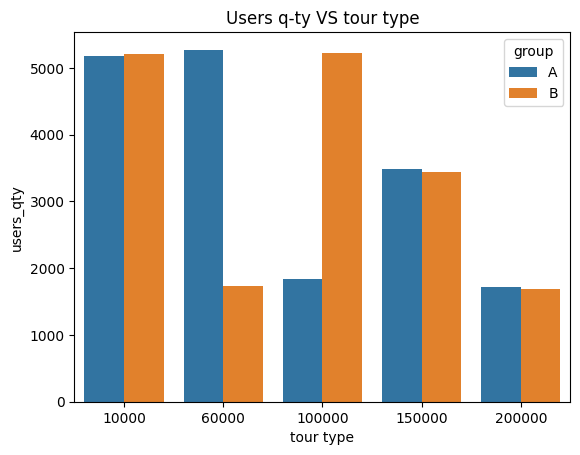

In [65]:
sns.barplot(df3[df3['price']!=0], x='price', y='users_qty', hue='group').set(title='Users q-ty VS tour type', xlabel='tour type');

    * The number of visits to both landing page options is comparable
    * Samples can be considered balanced by the number of visits
    * conversion, at first glance, is higher in group A, while the average check is higher in group B.
    * the difference in purchasing power between groups is most pronounced for tours of the 60,000 and 100,000 categories: in group A there is a relatively higher interest in cheaper tours (60,000), a mirror picture for tours of the 100,000 category: participants in group B purchased almost 3 times more such tours compared to group A. For other rounds, incl. category 0 (purchased nothing) - the numbers are comparable.

### 3. Analysis of the data to see if the metrics are stabilized

* Group data by date and testing group and build a table with daily data on the results of A/B testing. For each group, calculate the daily indicators:
     * number of page visits;
     * number of purchases;
     * amount of purchases.
* Add information to the table about the daily conversion (daily number of purchases / daily number of visits) in the group and the daily average check (daily amount of purchases / daily number of purchases).
* Calculate cumulative indicators:
     * cumulative number of page visits;
     * cumulative number of purchases;
     * cumulative amount of purchases.
* Based on the obtained cumulative indicators, calculate the cumulative conversion and the cumulative average bill.
* Build cumulative graphs of conversion and average check in each group by day.

Is the A/B test complete? Have the metric values stabilized over time? How do the cumulative scores compare in each group?


In [66]:
df4 = df.groupby(['date', 'group']).agg(
    {'user_id':'count',
     'purchase':'sum',
     'price':'sum'}
).reset_index().rename(columns={'user_id':'users_qty'})

df4['conversion'] = df4['purchase'] / df4['users_qty'] * 100
df4['av_check'] = df4['price'] / df4['purchase']

for g in ['A','B']:
    idx = df4[df4['group']==g].index
    df4.loc[idx,'users_qty_cum'] = df4.loc[idx,'users_qty'].cumsum() 
    df4.loc[idx,'purchase_cum'] = df4.loc[idx,'purchase'].cumsum() 
    df4.loc[idx,'price_cum'] = df4.loc[idx,'price'].cumsum() 

df4['conversion_cum'] = df4['purchase_cum'] / df4['users_qty_cum'] * 100
df4['av_check_cum'] = df4['price_cum'] / df4['purchase_cum'] * 100

display(df4.head())

metrics_mean_med = df4.groupby('group')[['conversion', 'av_check']].agg(['mean', 'median'])
display(metrics_mean_med)


,date,group,users_qty,purchase,price,conversion,av_check,users_qty_cum,purchase_cum,price_cum,conversion_cum,av_check_cum
0,2021-01-02,A,2854,359,29410000,12.578837,81922.005571,2854.0,359.0,29410000.0,12.578837,8.192201e+06
1,2021-01-02,B,2861,345,29660000,12.058721,85971.014493,2861.0,345.0,29660000.0,12.058721,8.597101e+06
2,2021-01-03,A,6595,748,62000000,11.341926,82887.700535,9449.0,1107.0,91410000.0,11.715525,8.257453e+06
3,2021-01-03,B,6619,754,65960000,11.391449,87480.106101,9480.0,1099.0,95620000.0,11.592827,8.700637e+06
4,2021-01-04,A,6564,799,64250000,12.172456,80413.016270,16013.0,1906.0,155660000.0,11.902829,8.166842e+06


conversion                 av_check              
            mean     median          mean        median
group                                                  
A      12.046456  12.033443  80969.285099  81922.005571
B      11.900468  11.833962  88575.715514  87770.935961

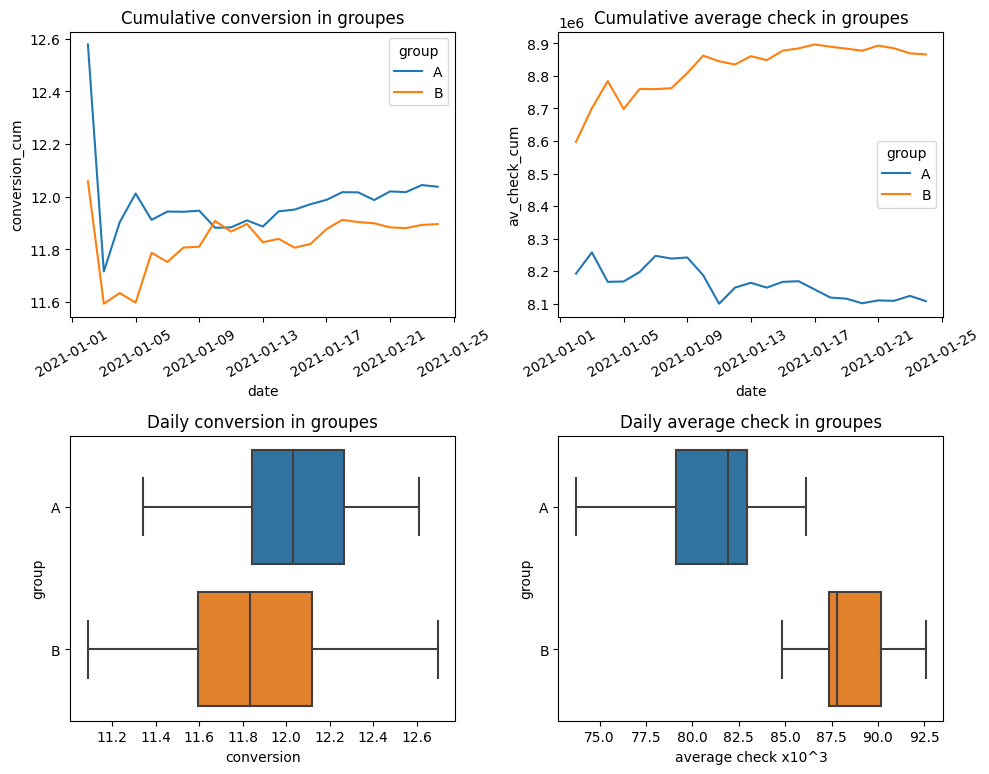

In [67]:
f,a = plt.subplots(2,2,figsize=(10,8))
sns.lineplot(df4, x='date', y='conversion_cum', hue='group', ax=a[0,0]).set(title='Cumulative conversion in groupes');
sns.lineplot(df4, x='date', y='av_check_cum', hue='group', ax=a[0,1]).set(title='Cumulative average check in groupes');
sns.boxplot(df4, x='conversion', y='group', ax=a[1,0]).set(title='Daily conversion in groupes');
sns.boxplot(df4, x=df4['av_check']/1000, y='group', ax=a[1,1]).set(title='Daily average check in groupes', xlabel='average check x10^3');

a[0,0].xaxis.set_tick_params(rotation=30)
a[0,1].xaxis.set_tick_params(rotation=30)

plt.tight_layout()

    * taking into account the stabilization of cumulative metrics, the A/B test can be considered completed. The duration of the test was chosen correctly.
    * the cumulative conversion throughout almost the entire testing period was slightly higher in group A (with the exception of a short period in the middle of testing). This is consistent with the slightly higher median daily conversion rate in Group A.
    * during testing, the cumulative average check was consistently higher in group B. The median value of the daily average check is also significantly higher in group B, but the spread of data on this indicator is smaller.

### 4. Statistical analysis of A/B testing results:
* Formulate statistical hypotheses relevant to business questions and select a statistical test to test them. Check data for normality where necessary.
* Using a statistical test apparatus, determine:
     * Is there a statistical difference between conversions in groups A and B?
     * Is there a statistical difference between the daily average checks in groups A and B?
* Support the results of statistical tests by constructing 95% confidence intervals for:
     * conversions in each group;
     * differences in conversions in groups;
     * daily average check in each group.
* Interpret the constructed confidence intervals for conversions and the daily average check in groups. Is there overlap between the confidence intervals for the groups? If so, what does this mean?


In [68]:
converted_piv = df.groupby('group')['purchase'].agg(['sum', 'count'])
display(converted_piv)

,sum,count
group,,
A,17487,145268
B,17290,145346


In [69]:
# z-test to assess the statistical significance of differences in conversion between groups.
# Н0: p(A) = p(B)
# Н1: p(A) != p(B)

alpha = 0.05 

_, p_value = proportions_ztest(
    count=converted_piv['sum'], 
    nobs=converted_piv['count'], 
    alternative='two-sided',
)

print('p-value: ', round(p_value, 3))

if (p_value <= alpha):
    print("We reject the H0 hypothesis in favor of the alternative")
else:
    print("We have no reason to reject the H0 hypothesis")

p-value:  0.238
We have no reason to reject the H0 hypothesis


    Taking into account the given level of significance, it is statistically significant that the conversions in the groups are equal.

p-value for group А 0.25
p-value for group B 0.09


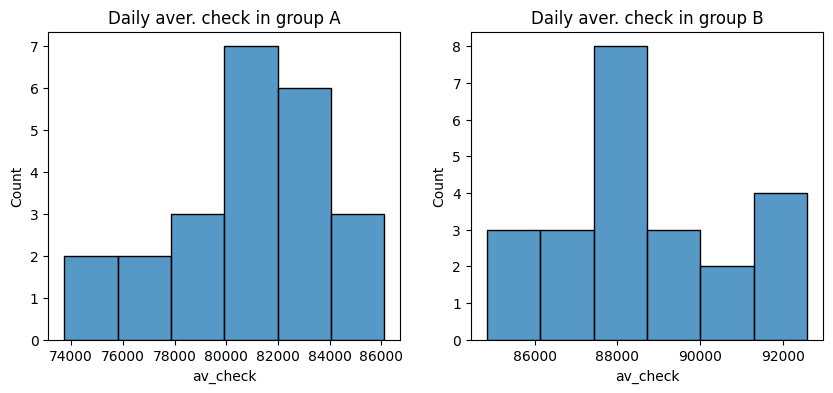

In [70]:
# statistic test for assessing daily average check in groupes

f, a = plt.subplots(1, 2, figsize=(10, 4))

sns.histplot(df4[df4['group']=='A'], x='av_check', ax=a[0]).set(title='Daily aver. check in group A');
sns.histplot(df4[df4['group']=='B'], x='av_check', ax=a[1]).set(title='Daily aver. check in group B');

# normality test. Shapiro
alpha = 0.05 
shapiro_a = shapiro(df4[df4['group']=='A']['av_check'])
shapiro_b = shapiro(df4[df4['group']=='B']['av_check'])
print('p-value for group А', round(shapiro_a.pvalue, 2))
print('p-value for group B', round(shapiro_b.pvalue, 2))


        
    Data are normally distributed in both groups. Parametric t-test can be used
    

In [71]:
# t-test for daily average check comparing
# H0: mu_a = mu_b
# H1: mu_a != mu_b

alpha = 0.05

results = ttest_ind(
    a=df4[df4['group']=='A']['av_check'],
    b=df4[df4['group']=='B']['av_check'],
    alternative='less'
)
print('p-value:', round(results.pvalue, 2))

if results.pvalue <= alpha:
    print("We reject the H0 hypothesis in favor of the alternative")
else:
    print("We have no reason to reject the H0 hypothesis")

p-value: 0.0
We reject the H0 hypothesis in favor of the alternative


    It is statistically significant that the daily average bill is lower in group A

In [72]:
def proportion_conf_interval(x_p, n, gamma=0.95):  
    """Count a confidence range bounds for proportion feature

    Args:
        x_p (aloat): feature mean value 
        n (int): set size
        gamma (float, optional): confidence level. Defaults to 0.95.

    Returns:
        float: range bounds
    """
    alpha = 1 - gamma
    z_crit = -norm.ppf(alpha/2) 
    eps = z_crit * (x_p * (1 - x_p) / n) ** 0.5 
    lower_bound = x_p - eps 
    upper_bound = x_p + eps
    return lower_bound, upper_bound


# confidence interval for conversion 
for g in ['A','B']:
    low_bound, up_bound = proportion_conf_interval(
    x_p=df[df['group']==g]['purchase'].mean(), 
    n=df[df['group']==g]['user_id'].count())
    print(f'Confidence range for conversion in group {g}: {round(low_bound * 100, 2), round(up_bound * 100, 2)}')


Confidence range for conversion in group A: (11.87, 12.21)
Confidence range for conversion in group B: (11.73, 12.06)


    with 95% reliability, the conversion of group A lies in the interval (11.87, 12.21)%, and the conversion of group B lies in the interval (11.73, 12.06)%.
    Confidence intervals for conversions in groups overlap.

In [73]:
def diff_proportion_conf_interval(x_p, n, gamma=0.95):
    """Count a confidence range bounds for proportions difference

    Args:
        x_p (list): feature mean values 
        n (list): set sizes
        gamma (float, optional): confidence level. Defaults to 0.95.

    Returns:
        float: range bounds
    """
    alpha = 1 - gamma
    diff = x_p[1] - x_p[0] 
    z_crit = -norm.ppf(alpha/2) 
    eps = z_crit * (x_p[0] * (1 - x_p[0])/n[0] + x_p[1] * (1 - x_p[1])/n[1]) ** 0.5 
    lower_bound = diff - eps 
    upper_bound = diff + eps 
    return lower_bound, upper_bound

n = [df[df['group']=='A']['user_id'].count(), df[df['group']=='B']['user_id'].count()]
x_p = [df[df['group']=='A']['purchase'].mean(), df[df['group']=='B']['purchase'].mean()]

# build a confidence interval for the difference in proportions
low_bound, up_bound = diff_proportion_conf_interval(x_p=x_p, n=n)
print(f'Confidence range for conversion difference: {(round(low_bound*100, 2), round(up_bound*100, 2))}')

Confidence range for conversion difference: (-0.38, 0.09)


    There is no statistically significant difference in conversion between groups A and B.

In [74]:
def t_mean_conf_interval(label, gamma=0.95):  
    """Count lower and upper bounds of a confidence range

    Args:
        label (str): group label
        gamma (float, optional): сщташвутсу думуд Defaults to 0.95.

    Returns:
        float: lower and upper bounds
    """
    alpha = 1 - gamma 
    n = df4[df4['group']==label]['av_check'].count()
    k = n - 1
    x_mean = df4[df4['group']==label]['av_check'].mean()
    x_std = df4[df4['group']==label]['av_check'].std()
    t_crit = -t.ppf(alpha/2, k) 
    eps = t_crit * x_std/(n ** 0.5) 
    lower_bound = x_mean - eps 
    upper_bound = x_mean + eps 
    return lower_bound, upper_bound

# confidence interval for the mean with an unknown standard deviation
for label in ['A','B']:
    low_bound, up_bound = t_mean_conf_interval(label)
    print(f'Confidence range for daily average check in group {label}: {(round(low_bound), round(up_bound))}')

Confidence range for daily average check in group A: (79630, 82308)
Confidence range for daily average check in group B: (87626, 89526)


    * With 95% confidence we can say that the true daily average check is in the interval
         * (79630, 82308) - for group A;
         * (87626, 89526) - for group B.
     * intervals for tested groups do not overlap. the difference is clearly expressed

### 5. Summary

    * Taking into account the given significance level (0.05), it is statistically significant that the conversions in the groups are equal. In addition, there is no statistically significant difference in conversion between groups A and B.
    * Taking into account the specified level of significance (0.05), it is statistically significant that the daily average bill is lower in group A
    
    Thus, main page design option B is more effective in terms of the daily average check metric. In terms of conversion metrics, both tested options are equivalent.
    